# Extracting Notes - symbol classification
This project consists in classifying different symbols present in a music sheet using different machine learning tehcniques.

Authors: Camilo Carvajal Reyes, Nicolás Acuña Reyes, Ibrahim Kaddouri, Houdaifa Ahmidan

## Data processing
First we retreive the data using the provided python library

In [1]:
import os
from muscima.io import parse_cropobject_list

# Change this to reflect wherever your MUSCIMA++ data lives
CROPOBJECT_DIR = os.path.join(os.environ['HOME'], 
                              'ML_course/Music_reading_project/MUSCIMA-pp_v0.9/v0.9/data/cropobjects')

cropobject_fnames = [os.path.join(CROPOBJECT_DIR, f) for f in os.listdir(CROPOBJECT_DIR)]
docs = [parse_cropobject_list(f) for f in cropobject_fnames]   

In [2]:
type(docs[0][0])

muscima.cropobject.CropObject

### Half notes and 4th notes classification
We start with a simple case. Both note symbols have a steam and no beam or flag. Half notes have an empty notehead. On the other hand, 4th notes have a full notehead. For further explanation see the report.

In [3]:
# bear in mind that the outlinks are integers, only valid within the same document.
# Therefore, we define a function per-document, not per-dataset.
def extract_notes_from_doc(cropobjects):
    """Finds all ``(full-notehead, stem)`` pairs that form
    quarter or half notes. Returns two lists of CropObject tuples:
    one for quarter notes, one of half notes.

    :returns: quarter_notes, half_notes
    """
    _cropobj_dict = {c.objid: c for c in cropobjects}

    notes = []
    for c in cropobjects:
        if (c.clsname == 'notehead-full') or (c.clsname == 'notehead-empty'):
            _has_stem = False
            _has_eflag = False
            _has_sflag = False
            _has_beam = False
            stem_obj = None
            efalg_obj = None
            sfalg_obj = None
            for o in c.outlinks:
                _o_obj = _cropobj_dict[o]
                if _o_obj.clsname == 'stem':
                    stem_obj = _o_obj
                    _has_stem = True
                _j_obj = _cropobj_dict[o]
                if _j_obj.clsname == '8th_flag':
                    _has_eflag = True
                    eflag_obj = _j_obj
                _k_obj = _cropobj_dict[o]
                if _k_obj.clsname == '16th_flag':
                    _has_sflag = True
                    sflag_obj = _k_obj
                elif _o_obj.clsname == 'beam':
                     _has_beam = True
            if _has_stem and (not _has_beam):    
                if  _has_eflag:
                    if _has_sflag:
                        notes.append((c, stem_obj, eflag_obj, sflag_obj))
                    else:
                        notes.append((c, stem_obj, eflag_obj))
                elif len(stem_obj.inlinks) == 1:
                        notes.append((c, stem_obj))
        

    quarter_notes = [n for n in notes if n[0].clsname == 'notehead-full' and len(n) == 2]
    half_notes = [n for n in notes if n[0].clsname == 'notehead-empty']
    e_notes = [n for n in notes if len(n) == 3]
    s_notes = [n for n in notes if len(n) == 4]
    return quarter_notes, half_notes, e_notes, s_notes

qns_hns_ens_sns = [extract_notes_from_doc(cropobjects) for cropobjects in docs]

### Clefs classification
The same principle can be generalised. This case is easier as clefs are not defined piecewise as half and quarter notes 

In [4]:
def extract_clefs_from_doc(cropobjects):
    _cropobj_dict = {c.objid: c for c in cropobjects}
    clefs = []
    for c in cropobjects:
        if c.clsname.endswith('clef'):
            clefs.append((c,c))
    g_clefs = [n for n in clefs if len(n) == 2 and n[0].clsname == 'g-clef']
    c_clefs = [n for n in clefs if len(n) == 2 and n[0].clsname == 'c-clef']
    f_clefs = [n for n in clefs if len(n) == 2 and n[0].clsname == 'f-clef']
    return g_clefs, c_clefs, f_clefs

gcs_ccs_fcs = [extract_clefs_from_doc(cropobjects) for cropobjects in docs]

### Dynamics classification
Symbols indicating dynamics are composed by one to three lettres 

In [5]:
def extract_dtext_from_doc(cropobjects):   #extract dynamics text
    _cropobj_dict = {c.objid: c for c in cropobjects}
    ps,pps,mps,fs,ffs,sfs,mfs,fps,sfzs= [], [], [], [], [], [], [], [], []
    for c in cropobjects:
        if c.clsname == 'dynamics_text':
            _has_p = False
            _has_f = False
            _has_m = False
            _has_s = False
            if len(c.outlinks) == 1:
                letter = _cropobj_dict[c.outlinks[0]]
                if letter.clsname.endswith('p'):
                    ps.append((c,c))
                if letter.clsname.endswith('f'):
                    fs.append((c,c))
            elif len(c.outlinks) == 2:
                for j in c.outlinks:
                    _j_obj = _cropobj_dict[j]
                    if _j_obj.clsname.endswith('p'):
                        _has_p = True
                    elif _j_obj.clsname.endswith('f'):
                        _has_f = True
                    elif _j_obj.clsname.endswith('m'):
                        _has_m = True
                    elif _j_obj.clsname.endswith('s'):
                        _has_s = True
                if _has_p and _has_f :
                    fps.append((c,c))
                elif _has_p and _has_m :
                    mps.append((c,c))
                elif _has_m and _has_f :
                    mfs.append((c,c))
                elif _has_p and (not _has_m) and (not _has_f):
                    pps.append((c,c))
                elif _has_f and (not _has_p) and (not _has_m) and (not _has_s):
                    ffs.append((c,c))
                elif _has_f and _has_s:
                    sfs.append((c,c))
            elif len(c.outlinks) == 3:
                sfzs.append((c,c))
                    
    return pps, ps, mps, mfs, fs, ffs, sfs, fps, sfzs


dtexts = [extract_dtext_from_doc(cropobjects) for cropobjects in docs]

### Extracting keys
Then keys are denoted at the begining of each line by flats and sharps. Then the tonality of the music is determined by which notes are sharp or flat. For instance, F sharp and C sharp denote that the music is either in the key of D or in the key of B minor. In this data set, sharps and flats denoting the key are considered appart of the accidental ones. Furthermore, they are grouped together for each key pair.

In [6]:
def extract_keys_from_doc(cropobjects):   #extract dynamics text
    _cropobj_dict = {c.objid: c for c in cropobjects}
    GEs, DBs, AFss, ECss, BGss, FsDss, CsAss, FDs = [], [], [], [], [], [], [], []
    BfGs, EfCs, AfFs, DfBfs, GfEfs, CfAfs = [], [], [], [], [], []
    for c in cropobjects:
        if c.clsname == 'key_signature':
            if _cropobj_dict[c.outlinks[0]].clsname == 'sharp':
                if len(c.outlinks) == 1 :
                    GEs.append((c,c))
                if len(c.outlinks) == 2 :
                    DBs.append((c,c))
                if len(c.outlinks) == 3 :
                    AFss.append((c,c))
                if len(c.outlinks) == 4 :
                    ECss.append((c,c))
                if len(c.outlinks) == 5 :
                    BGss.append((c,c))
                if len(c.outlinks) == 6 :
                    FsDss.append((c,c))
                if len(c.outlinks) == 7 :
                    CsAss.append((c,c))
            elif _cropobj_dict[c.outlinks[0]].clsname == 'flat':
                if len(c.outlinks) == 1 :
                    FDs.append((c,c))
                if len(c.outlinks) == 2 :
                    BfGs.append((c,c))
                if len(c.outlinks) == 3 :
                    EfCs.append((c,c))
                if len(c.outlinks) == 4 :
                    AfFs.append((c,c))
                if len(c.outlinks) == 5 :
                    DfBfs.append((c,c))
                if len(c.outlinks) == 6 :
                    GfEfs.append((c,c))
                if len(c.outlinks) == 7 :
                    CfAfs.append((c,c))
                    
    return  GEs, DBs, AFss, ECss, BGss, FsDss, CsAss, FDs, BfGs, EfCs, AfFs, DfBfs, GfEfs, CfAfs

keys = [extract_keys_from_doc(cropobjects) for cropobjects in docs]

### Amount of elements per symbol

In [7]:
import itertools
def len_notes():
    qns = list(itertools.chain(*[qn for qn, hn, en, sn in qns_hns_ens_sns]))
    hns = list(itertools.chain(*[hn for qn, hn, en, sn in qns_hns_ens_sns]))
    ens = list(itertools.chain(*[en for qn, hn, en, sn in qns_hns_ens_sns]))
    sns = list(itertools.chain(*[sn for qn, hn ,en, sn in qns_hns_ens_sns]))
    print("# of quarter notes = {}".format(len(qns)))
    print("# of quarter notes = {}".format(len(hns)))
    print("# of quarter notes = {}".format(len(ens)))
    print("# of quarter notes = {}".format(len(sns)))
    return qns, hns, ens, sns
qns, hns, ens, sns = len_notes()

# of quarter notes = 4331
# of quarter notes = 1181
# of quarter notes = 1753
# of quarter notes = 390


In [8]:
def len_clefs():
    gcs = list(itertools.chain(*[gc for gc, cc, fc in gcs_ccs_fcs]))
    ccs = list(itertools.chain(*[cc for gc, cc, fc in gcs_ccs_fcs]))
    fcs = list(itertools.chain(*[fc for gc, cc, fc in gcs_ccs_fcs]))
    print("# of g-clefs = {}".format(len(gcs)))
    print("# of alto clefs = {}".format(len(ccs)))
    print("# of bass clefs = {}".format(len(fcs)))
    return gcs, ccs, fcs
gcs, ccs, fcs = len_clefs()

# of g-clefs = 401
# of alto clefs = 190
# of bass clefs = 285


In [9]:
# these are the key signatures we have in the data
def len_keys():
    dic = {}
    keys_str=['GE', 'DB', 'AFs', 'ECs', 'BGs', 'FsDs', 'CsAs', 'FD', 'BfG', 'EfC', 'AfF', 'DfBf', 'GfEf', 'CfAf']
    for key in keys_str:
        index = keys_str.index(key)
        dic[key] = list(itertools.chain(*[[GE, DB, AFs, ECs, BGs, FsDs, CsAs,FD,
                                           BfG, EfC, AfF, DfBf, GfEf, CfAf][index] 
                                          for GE, DB, AFs, ECs, BGs, FsDs, CsAs, 
                                 FD, BfG, EfC, AfF, DfBf, GfEf, CfAf in keys]))
        print("# of {} key signatures = {}".format(key,len(dic[key])))
    return dic
GEs, DBs, AFs, ECs, BGs, FsDs, CsAs,FDs, BfGs, EfCs, AfFs, DfBfs, GfEfs, CfAfs = tuple(len_keys().values())

# of GE key signatures = 269
# of DB key signatures = 172
# of AFs key signatures = 0
# of ECs key signatures = 0
# of BGs key signatures = 0
# of FsDs key signatures = 0
# of CsAs key signatures = 0
# of FD key signatures = 9
# of BfG key signatures = 78
# of EfC key signatures = 80
# of AfF key signatures = 80
# of DfBf key signatures = 0
# of GfEf key signatures = 0
# of CfAf key signatures = 0


We keep GE DB BfG EfC AfF from now on, not enough data for the rest

In [10]:
# these are the dynamics texts we have in the database
def len_dynamics():
    dic = {}
    din_str=['pp', 'p', 'mp', 'mf', 'f', 'ff', 'sf', 'fp', 'sfz']
    for din in din_str:
        index = din_str.index(din)
        dic[din] = list(itertools.chain(*[[pp, p, mp, mf, f, ff, sf, fp, sfz][index] 
                                          for pp, p, mp, mf, f, ff, sf, fp, sfz in dtexts]))
        print("# of dynamic {} = {}".format(din,len(dic[din])))
    return dic
pps, ps, mps, mfs, fs, ffs, sfs, fps, sfzs = tuple(len_dynamics().values())

# of dynamic pp = 68
# of dynamic p = 193
# of dynamic mp = 6
# of dynamic mf = 48
# of dynamic f = 111
# of dynamic ff = 112
# of dynamic sf = 48
# of dynamic fp = 22
# of dynamic sfz = 37


We only have 6 mp's so we don't consider it for the classification

## Getting images
Images can be retreived by reconstructing the image using the binary representation

In [11]:
import numpy

def get_image(cropobjects, margin=1):
    """Paste the cropobjects' mask onto a shared canvas.
    There will be a given margin of background on the edges."""

    # Get the bounding box into which all the objects fit
    top = min([c.top for c in cropobjects])
    left = min([c.left for c in cropobjects])
    bottom = max([c.bottom for c in cropobjects])
    right = max([c.right for c in cropobjects])

    # Create the canvas onto which the masks will be pasted
    height = bottom - top + 2 * margin
    width = right - left + 2 * margin
    canvas = numpy.zeros((height, width), dtype='uint8')

    for c in cropobjects:
        # Get coordinates of upper left corner of the CropObject
        # relative to the canvas
        _pt = c.top - top + margin
        _pl = c.left - left + margin
        # We have to add the mask, so as not to overwrite
        # previous nonzeros when symbol bounding boxes overlap.
        canvas[_pt:_pt+c.height, _pl:_pl+c.width] += c.mask

    canvas[canvas > 0] = 1
    return canvas

In [12]:
def get_note_images():
    qn_images = [get_image(qn) for qn in qns]
    hn_images = [get_image(hn) for hn in hns]
    en_images = [get_image(en) for en in ens]
    sn_images = [get_image(sn) for sn in sns]
    return qn_images, hn_images, en_images, sn_images
qn_images, hn_images, en_images, sn_images = get_note_images()

def get_clef_images():
    gc_images = [get_image(gc) for gc in gcs]
    cc_images = [get_image(cc) for cc in ccs]
    fc_images = [get_image(fc) for fc in fcs]
    return gc_images, cc_images, fc_images
gc_images, cc_images, fc_images = get_clef_images()

def get_key_images():
    GE_images = [get_image(GE) for GE in GEs]
    DB_images = [get_image(DB) for DB in DBs]
    BfG_images = [get_image(BfG) for BfG in BfGs]
    EfC_images = [get_image(EfC) for EfC in EfCs]
    AfF_images = [get_image(AfF) for AfF in AfFs]
    return GE_images, DB_images, BfG_images, EfC_images, AfF_images
GE_images, DB_images, BfG_images, EfC_images, AfF_images = get_key_images()

#dynamics texts :
def get_din_images():
    p_images = [get_image(p) for p in ps]
    pp_images = [get_image(pp) for pp in pps]
    ff_images = [get_image(ff) for ff in ffs]
    sf_images = [get_image(sf) for sf in sfs]
    fp_images = [get_image(fp) for fp in fps]
    f_images = [get_image(f) for f in fs]
    sfz_images = [get_image(sfz) for sfz in sfzs]
    mf_images = [get_image(mf) for mf in mfs]
    return pp_images, p_images, mf_images, f_images, ff_images, sf_images, fp_images, sfz_images
pp_images, p_images, mf_images, f_images, ff_images, sf_images, fp_images, sfz_images = get_din_images()

### From binary to actual image

In [13]:
import matplotlib.pyplot as plt

def show_mask(mask):
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()

def show_masks(masks, row_length=5):
    n_masks = len(masks)
    n_rows = n_masks // row_length + 1
    n_cols = min(n_masks, row_length)
    fig = plt.figure()
    for i, mask in enumerate(masks):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(mask, cmap='gray', interpolation='nearest')
    # Let's remove the axis labels, they clutter the image.
    for ax in fig.axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()

### Showing mask for a given symbol set

In [14]:
def show_mask_notes():
    qn_images, hn_images, en_images, sn_images = get_note_images()
    for note in [qn_images, hn_images, en_images, sn_images]:
        show_masks(note[:25])

def show_mask_clefs():
    gc_images, cc_images, fc_images = get_clef_images()
    for clef in [gc_images, cc_images, fc_images]:
        show_masks(clef[:25])

#key signatures
def show_mask_keys():
    GE_images, DB_images, BfG_images, EfC_images, AfF_images = get_key_images()
    for key in [GE_images, DB_images, BfG_images, EfC_images, AfF_images]:
        show_masks(key[:25])


#dynamics text:
def show_mask_dynamics():
    pp_images, p_images, mf_images, f_images, ff_images, sf_images, fp_images, sfz_images = get_din_images()
    for din in [pp_images, p_images, mf_images, f_images, ff_images, sf_images, fp_images, sfz_images]:
        show_masks(din[:25])
    
    
#show_mask_notes()
#show_mask_clefs()
#show_mask_keys()
#show_mask_dynamics()

In [17]:
from skimage.transform import resize
# And re-binarize, to compensate for interpolation effects
#notes
notes_size=(150,90)
def resize_notes():
    en_resized = [resize(en, notes_size) for en in en_images]
    sn_resized = [resize(sn, notes_size) for sn in sn_images]
    qn_resized = [resize(qn, notes_size) for qn in qn_images]
    hn_resized = [resize(hn, notes_size) for hn in hn_images]

    for en in en_resized:
        en[en > 0] = 1
    for sn in sn_resized:
        sn[sn > 0] = 1
    for qn in qn_resized:
        qn[qn > 0] = 1
    for hn in hn_resized:
        hn[hn > 0] = 1
    return en_resized, sn_resized, qn_resized, hn_resized
#en_resized, sn_resized, qn_resized, hn_resized = resize_notes()

clef_size = (150, 90)
def resize_clefs():
    gc_resized = [resize(gc,clef_size) for gc in gc_images]
    cc_resized = [resize(cc, clef_size) for cc in cc_images]
    fc_resized = [resize(fc, clef_size) for fc in fc_images]

    for gc in gc_resized:
        gc[gc > 0] = 1
    for cc in cc_resized:
        cc[cc > 0] = 1
    for fc in fc_resized:
        fc[fc > 0] = 1
    return gc_resized, cc_resized, fc_resized
#gc_resized, cc_resized, fc_resized = resize_clefs()
   
size_signatures = (150,90)
def resize_signatures():
    GE_resized = [resize(GE, size_signatures) for GE in GE_images ]
    DB_resized = [resize(DB, size_signatures) for DB in DB_images ]
    BfG_resized = [resize(BfG, size_signatures) for BfG in BfG_images ] 
    EfC_resized = [resize(EfC, size_signatures) for EfC in EfC_images ]
    AfF_resized = [resize(AfF, size_signatures) for AfF in AfF_images ]

    for GE in GE_resized:
        GE[GE > 0] = 1
    for DB in DB_resized:
        DB[DB > 0] = 1
    for BfG in BfG_resized:
        BfG[BfG > 0] = 1
    for EfC in EfC_resized:
        EfC[EfC > 0] = 1
    for AfF in AfF_resized:
        AfF[AfF > 0] = 1
    return GE_resized, DB_resized, BfG_resized, EfC_resized, AfF_resized
#GE_resized, DB_resized, BfG_resized, EfC_resized, AfF_resized = resize_signatures()


size_dynamics = (100,100)
def resize_dynamics():
    p_resized = [resize(p, size_dynamics) for p in p_images]
    pp_resized = [resize(pp,size_dynamics) for pp in pp_images]
    fp_resized = [resize(fp, size_dynamics) for fp in fp_images]
    f_resized = [resize(f, size_dynamics) for f in f_images]
    ff_resized = [resize(ff,size_dynamics) for ff in ff_images]
    sf_resized = [resize(sf, size_dynamics) for sf in sf_images]
    mf_resized = [resize(mf, size_dynamics) for mf in mf_images]
    sfz_resized = [resize(sfz, size_dynamics) for sfz in sfz_images]
    for dyn_rs in [p_resized, pp_resized, fp_resized, f_resized, ff_resized, sf_resized, mf_resized, sfz_resized]:
        for dyn in dyn_rs:
            dyn[dyn > 0] = 1
    return pp_resized, p_resized, mf_resized, f_resized, ff_resized, sf_resized, fp_resized, sfz_resized

pp_resized, p_resized, mf_resized, f_resized, ff_resized, sf_resized, fp_resized, sfz_resized=resize_dynamics()

Example of visualization of resized images

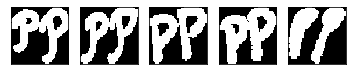

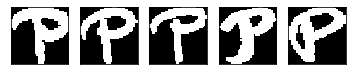

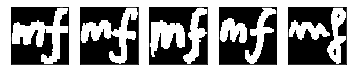

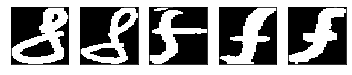

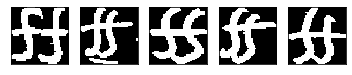

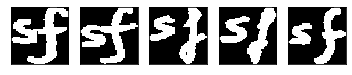

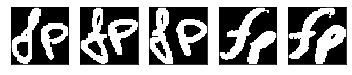

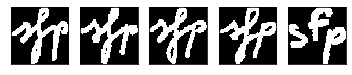

In [18]:
for dyn_rs in [pp_resized, p_resized, mf_resized, f_resized, ff_resized, sf_resized, fp_resized, sfz_resized]:
    show_masks(dyn_rs[:5])

Now in order to have a better classification we'll balance the sets

In [19]:
import random

def balance_notes():
    en_resized, sn_resized, qn_resized, hn_resized = resize_notes()
    n_sns = len(sn_resized) #less numerous set
    random.shuffle(qn_resized)
    qn_selected = qn_resized[:n_sns]
    random.shuffle(hn_resized)
    hn_selected = hn_resized[:n_sns]
    random.shuffle(en_resized)
    en_selected = en_resized[:n_sns]
    return qn_selected, hn_selected, en_selected
#qn_selected, hn_selected, en_selected = balance_notes()

def balance_clefs():
    gc_resized, cc_resized, fc_resized = resize_clefs()
    n_cc = len(fc_resized)
    random.shuffle(gc_resized)
    gc_selected = gc_resized[:n_cc]
    random.shuffle(fc_resized)
    fc_selected = fc_resized[:n_cc]
    return gc_selected, fc_selected
#gc_selected, fc_selected = balance_clefs()

def balance_keys():
    GE_resized, DB_resized, BfG_resized, EfC_resized, AfF_resized = resize_signatures()
    n_BfG = len(BfG_resized)
    random.shuffle(GE_resized)
    GE_selected = GE_resized[:n_BfG]
    random.shuffle(DB_resized)
    DB_selected = DB_resized[:n_BfG]
    random.shuffle(EfC_resized)
    EfC_selected = EfC_resized[:n_BfG]
    random.shuffle(AfF_resized)
    AfF_selected = AfF_resized[:n_BfG]
    return GE_selected, DB_selected, EfC_selected, AfF_selected
#GE_selected, DB_selected, EfC_selected, AfF_selected = balance_keys()

def balance_dynamics():
    p_resized, pp_resized, fp_resized, f_resized, ff_resized, sf_resized, mf_resized, sfz_resized=resize_dynamics()
    n = len(sf_resized)
    random.shuffle(p_resized)
    p_selected = p_resized[:n]
    random.shuffle(pp_resized)
    pp_selected = pp_resized[:n]
    random.shuffle(f_resized)
    f_selected = f_resized[:n]
    random.shuffle(ff_resized)
    ff_selected = ff_resized[:n]
    random.shuffle(sf_resized)
    sf_selected = sf_resized[:n]
    random.shuffle(mf_resized)
    mf_selected = mf_resized[:n]
    return p_selected, pp_selected,  mf_selected, f_selected, ff_selected, sf_selected
#p_selected, pp_selected,  mf_selected, f_selected, ff_selected, sf_selected = balance_dynamics()


In [65]:
#notes 
def labels_notes():
    qn_selected, hn_selected, en_selected = balance_notes()
    E_LABEL = 1
    Q_LABEL = 2
    H_LABEL = 3

    en_labels = [E_LABEL for _ in en_selected]
    qn_labels = [Q_LABEL for _ in qn_selected]
    hn_labels = [H_LABEL for _ in hn_selected]

    notes = en_selected + qn_selected + hn_selected
    notes_flattened = [n.flatten() for n in notes]  #flatten data
    labels = en_labels + qn_labels + hn_labels
    return notes, notes_flattened, labels
#notes, notes_flattened, labels = labels_notes()

def labels_clefs():
    gc_selected, fc_selected = balance_clefs()
    G_LABEL = 4
    F_LABEL = 6

    gc_labels = [G_LABEL for _ in gc_selected]
    fc_labels = [F_LABEL for _ in fc_selected]

    clefs = gc_selected + fc_selected
    clefs_flattened = [n.flatten() for n in clefs]  #flatten data
    labels = gc_labels + fc_labels
    return notes, clefs_flattened, labels
#notes, notes_flattened, labels = labels_clefs()

def labels_keys():
    GE_selected, DB_selected, EfC_selected, AfF_selected = balance_keys()
    GE_LABEL = 8
    DB_LABEL = 9
    EfC_LABEL = 10
    AfF_LABEL = 11

    GE_labels = [GE_LABEL for _ in GE_selected]
    DB_labels = [DB_LABEL for _ in DB_selected]
    EfC_labels = [EfC_LABEL for _ in EfC_selected]
    AfF_labels = [AfF_LABEL for _ in AfF_selected]

    keys =  GE_selected + DB_selected + EfC_selected + AfF_selected
    keys_flattened = [n.flatten() for n in keys]  #flatten data
    labels = GE_labels + DB_labels + EfC_labels + AfF_labels
    return notes, keys_flattened, labels
#notes, notes_flattened, labels = labels_keys()

def labels_dyn():
    p_selected, pp_selected,  mf_selected, f_selected, ff_selected, sf_selected = balance_dynamics()
    pp_LABEL = 12 
    p_LABEL = 13
    mf_LABEL = 14
    f_LABEL = 15
    ff_LABEL = 16
    sf_LABEL = 17

    p_labels = [p_LABEL for _ in p_selected]
    pp_labels = [pp_LABEL for _ in pp_selected]
    f_labels = [f_LABEL for _ in f_selected]
    ff_labels = [ff_LABEL for _ in ff_selected]
    sf_labels = [sf_LABEL for _ in sf_selected]
    mf_labels = [mf_LABEL for _ in mf_selected]

    dtexts = pp_selected + p_selected + mf_selected + f_selected 
    dtexts = dtexts + ff_selected + sf_selected 
    dtexts_flattened = [n.flatten() for n in dtexts]  #flatten data
    labels = pp_labels + p_labels + mf_labels + f_labels + ff_labels + sf_labels
    return notes, dtexts_flattened, labels
#notes, notes_flattened, labels = labels_dyn()


In [54]:
from sklearn.model_selection import train_test_split

def train_notes():
    notes, notes_flattened, labels = labels_notes()
    X_train, X_test, y_train, y_test = train_test_split(
        notes_flattened, labels, test_size=0.25, random_state=42,
        stratify=labels)
    return  X_train, X_test, y_train, y_test
#X_train, X_test, y_train, y_test = train_notes()

In [66]:
def train_clefs():
    notes, clefs_flattened, labels = labels_clefs()
    X_train, X_test, y_train, y_test = train_test_split(clefs_flattened, labels,
                                                        test_size=0.25, random_state=42,stratify=labels)
    return X_train, X_test, y_train, y_test
#X_train, X_test, y_train, y_test = train_clefs()

In [56]:
def train_keys():
    notes, keys_flattened, labels = labels_keys()
    X_train, X_test, y_train, y_test = train_test_split(
        keys_flattened, labels, test_size=0.25, random_state=42,stratify=labels)
    return X_train, X_test, y_train, y_test
#X_train, X_test, y_train, y_test = train_keys()

In [57]:
def train_dyn():
    notes, dtexts_flattened, labels = labels_dyn()
    X_train, X_test, y_train, y_test = train_test_split(dtexts_flattened, labels, 
                                                        test_size=0.25, random_state=42,stratify=labels)
    return X_train, X_test, y_train, y_test
#X_train, X_test, y_train, y_test = train_dyn()

In [67]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

def classifiers(case):
    #case = notes, clefs, keys or dynamics
    if case=='notes':
        X_train, X_test, y_train, y_test = train_notes()
    elif case=='clefs':
        X_train, X_test, y_train, y_test = train_clefs()
    elif case=='keys':
        X_train, X_test, y_train, y_test = train_keys()
    elif case=='dynamics':
        X_train, X_test, y_train, y_test = train_dyn()
    else:
        print("error: pick correct case (notes, clefs, keys or dynamics)")
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train, y_train)

    clf2 = RandomForestClassifier(n_estimators=300, random_state=0)  #porqué en 200?
    clf2.fit(X_train, y_train)

    clf3 = svm.SVC(decision_function_shape='ovo') #ver estos parametros
    clf3.fit(X_train, y_train)

    clf4 = AdaBoostClassifier(n_estimators=600, random_state=0)  #porqué en 600?
    clf4.fit(X_train, y_train)

    clf5=MLPClassifier(hidden_layer_sizes=(30,30,30))
    clf5.fit(X_train, y_train)
    return clf, clf2, clf3, clf4, clf5, X_train, X_test, y_train, y_test


In [68]:
def predict(case):
    clf, clf2, clf3, clf4, clf5, X_train, X_test, y_train, y_test = classifiers(case)
    y_test_pred = clf.predict(X_test)
    y_test_pred2 = clf2.predict(X_test)
    y_test_pred3 = clf3.predict(X_test)
    y_test_pred4 = clf4.predict(X_test)
    y_test_pred5 = clf5.predict(X_test)
    return y_test_pred, y_test_pred2, y_test_pred3, y_test_pred4, y_test_pred5, y_test

In [72]:
from sklearn.metrics import classification_report
notes=['8th note', 'quarter note', 'half note']
clef=['g-clef', 'f-clef']
key=[ 'G major E minor', 'D major B minor', 'E-flat major C minor', 'A-flat major F minor']
dynamic=['pianissimo', 'piano','mezzo forte' , 'forte', 'fortissimo', 'sforzando']

#Label: notes,clef,key or dynamic
def evaluate(case):
    y_test_pred, y_test_pred2, y_test_pred3, y_test_pred4, y_test_pred5, y_test = predict(case)
    if case=='notes':
        label=notes
    elif case=='clefs':
        label=clef
    elif case=='keys':
        label=key
    elif case=='dynamics':
        label=dynamic
    print('----------- Model : ',1,'K-NN ---------------------')
    print(classification_report(y_test, y_test_pred, target_names=label))

    print('----------- Model :',2,'Random Forest ------------')
    print(classification_report(y_test, y_test_pred2, target_names=label))

    print('----------- Model ',3,'SVM     --------------------')
    print(classification_report(y_test, y_test_pred3, target_names=label))

    print('----------- Model ',4,'Adaboost     ------------------')
    print(classification_report(y_test, y_test_pred4, target_names=label))

    print('----------- Model ',5,'Neuronal Network  ---------------')
    print(classification_report(y_test, y_test_pred5, target_names=label))

In [51]:
evaluate('dynamics')

/home/camilo/miniconda3/envs/ML_course/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


----------- Model :  1 K-NN ---------------------
              precision    recall  f1-score   support

  pianissimo       0.75      1.00      0.86        12
       piano       0.92      0.92      0.92        12
 mezzo forte       1.00      0.50      0.67         6
       forte       0.75      0.75      0.75        12
  fortissimo       0.80      0.67      0.73        12
   sforzando       0.85      0.92      0.88        12

    accuracy                           0.82        66
   macro avg       0.84      0.79      0.80        66
weighted avg       0.83      0.82      0.81        66

----------- Model : 2 Random Forest ------------
              precision    recall  f1-score   support

  pianissimo       1.00      1.00      1.00        12
       piano       0.92      1.00      0.96        12
 mezzo forte       0.75      0.50      0.60         6
       forte       0.80      1.00      0.89        12
  fortissimo       0.80      0.67      0.73        12
   sforzando       0.92      0.92

/home/camilo/miniconda3/envs/ML_course/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
evaluate('keys')

/home/camilo/miniconda3/envs/ML_course/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


----------- Model :  1 K-NN ---------------------
                      precision    recall  f1-score   support

     G major E minor       1.00      0.95      0.97        20
     D major B minor       1.00      0.95      0.97        19
E-flat major C minor       1.00      0.75      0.86        20
A-flat major F minor       0.73      1.00      0.84        19

            accuracy                           0.91        78
           macro avg       0.93      0.91      0.91        78
        weighted avg       0.93      0.91      0.91        78

----------- Model : 2 Random Forest ------------
                      precision    recall  f1-score   support

     G major E minor       0.95      0.95      0.95        20
     D major B minor       0.95      0.95      0.95        19
E-flat major C minor       1.00      0.95      0.97        20
A-flat major F minor       0.95      1.00      0.97        19

            accuracy                           0.96        78
           macro avg       0

In [70]:
evaluate('clefs')

/home/camilo/miniconda3/envs/ML_course/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


----------- Model :  1 K-NN ---------------------
              precision    recall  f1-score   support

      g-clef       0.89      1.00      0.94        72
      f-clef       1.00      0.87      0.93        71

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143

----------- Model : 2 Random Forest ------------
              precision    recall  f1-score   support

      g-clef       0.99      0.99      0.99        72
      f-clef       0.99      0.99      0.99        71

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

----------- Model  3 SVM     --------------------
              precision    recall  f1-score   support

      g-clef       0.99      1.00      0.99        72
      f-clef       1.00      0.99      0.99        71

    accuracy                     

In [73]:
evaluate('notes')

/home/camilo/miniconda3/envs/ML_course/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


----------- Model :  1 K-NN ---------------------
              precision    recall  f1-score   support

    8th note       1.00      0.95      0.97        97
quarter note       0.80      0.98      0.88        98
   half note       0.96      0.80      0.87        98

    accuracy                           0.91       293
   macro avg       0.92      0.91      0.91       293
weighted avg       0.92      0.91      0.91       293

----------- Model : 2 Random Forest ------------
              precision    recall  f1-score   support

    8th note       0.95      0.99      0.97        97
quarter note       0.93      0.95      0.94        98
   half note       0.97      0.91      0.94        98

    accuracy                           0.95       293
   macro avg       0.95      0.95      0.95       293
weighted avg       0.95      0.95      0.95       293

----------- Model  3 SVM     --------------------
              precision    recall  f1-score   support

    8th note       0.95      0.97 